# Задача: Предсказание 3-х самых вероятных категорий (тэгов) для новостей

Работать будем с датасетом новостей с РИА-новости за 2018 год. 
Каждой новости в соотвествие поставлены ключевые слова - категории новости. Требуется научиться предсказывать категории по тексту новости. Будем предсказывать для каждой новости три самых вероятных категории.

### 1. Подгрузка библиотек и данных 

In [3]:
import pandas as pd  # для таблиц
import numpy as np   # для матриц

# визуализация 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import re # библиотека для регулярных выражений

# лемматизатор
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# список стоп-слов
import nltk
stopwords = set([word for word in nltk.corpus.stopwords.words('russian') if word != 'не'])

# удобный словарь
from collections import defaultdict

# слои для нейронок, которые нам пригодятся 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [4]:
# путь к рабочей папке
import pathlib
workdir = pathlib.Path().absolute()

# отключаем warning-и
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pickle
with open(f'{workdir}/text_news_twitter/ria_news_2018.pickle', 'rb') as f:
    ria_news = pickle.load(f, encoding='utf-8')

In [29]:
ria_news[2]

{'category': '',
 'date': '2018-12-31',
 'day': '31',
 'href': '/20181231/1548961337.html',
 'image': 'https://cdn25.img.ria.ru/images/rsport/113508/49/1135084902_0:0:3000:1688_1036x0_80_0_0_a23eb1a67591477fba1ccd2840e9f955.jpg',
 'keywords': 'фк арсенал (лондон)',
 'month': '12',
 'shows': '183',
 'snippet': 'Полузащитник лондонского "Арсенала" Аарон Рэмзи рассматривает пять вариантов продолжения карьеры, футболист намерен начать переговоры о переходе в другой клуб в Спорт РИА Новости, 31.12.2018',
 'tags': 'ФК Арсенал (Лондон)',
 'text': 'МОСКВА, 31 дек - РИА Новости. Полузащитник лондонского "Арсенала" Аарон Рэмзи рассматривает пять вариантов продолжения карьеры, футболист намерен начать переговоры о переходе в другой клуб в январе, сообщает Би-би-си. Срок контракта 28-летнего валлийского хавбека с "канонирами" истекает в конце июня текущего года. Стороны не смогли достичь договоренности о продлении соглашения. Как отмечается в материале, Рэмси намерен вести переговоры с немецкой "Б

### 2. Предобработка категорий
Для дальнейшей работы отфильтруем категории, удалив самые редкие.

In [10]:
category = [news['category'] for news in ria_news]

In [32]:
cat_uniq = set(category)
cat_uniq 

{'',
 'Акценты - Радио Sputnik',
 'АртВывих',
 'В мире',
 'Видеоблоги - Радио Sputnik',
 'Инфографика',
 'Культура',
 'Навигатор абитуриента',
 'Наука',
 'Недвижимость',
 'Общество',
 'Политика',
 'Программы - Радио Sputnik',
 'Происшествия',
 'Радио',
 'Религия',
 'Сказано в эфире - Радио Sputnik',
 'Социальный навигатор',
 'Спецпроекты - Радио Sputnik',
 'Спорт',
 'Теория заблуждений',
 'Туризм',
 'Экономика'}

In [33]:
cat_dict = {i:category.count(i) for i in category}

In [65]:
cats_to_drop = []
cats_done = []

RARE_CAT_PERCENTAGE = 2

print('Процентное соотношение категорий в RIA-новостях:')
for key, value in cat_dict.items():
    print('   {}: {:.2f}  %'.format(key, value/len(ria_news)*100))
    if key == '':
        cats_to_drop.append(key)
    if value/len(ria_news)*100 <= RARE_CAT_PERCENTAGE:
        cats_to_drop.append(key)
print("-"*50)
print(f'Редкие категории (для удаления): {cats_to_drop}')
cat_done = [ elem for elem in cat_uniq if elem not in cats_to_drop]
print("-"*50)
print(f'Итоговые категории (для анализа): {cat_done}')

Процентное соотношение категорий в RIA-новостях:
   В мире: 24.81  %
   : 16.30  %
   Общество: 8.40  %
   Происшествия: 9.06  %
   Религия: 1.33  %
   Наука: 2.31  %
   Туризм: 1.68  %
   Экономика: 6.81  %
   Недвижимость: 3.62  %
   Политика: 3.94  %
   Акценты - Радио Sputnik: 0.52  %
   Культура: 2.06  %
   Программы - Радио Sputnik: 0.09  %
   Спорт: 15.67  %
   Сказано в эфире - Радио Sputnik: 1.58  %
   Видеоблоги - Радио Sputnik: 0.23  %
   Радио: 0.08  %
   Социальный навигатор: 1.21  %
   Навигатор абитуриента: 0.18  %
   Инфографика: 0.08  %
   АртВывих: 0.01  %
   Теория заблуждений: 0.02  %
   Спецпроекты - Радио Sputnik: 0.00  %
--------------------------------------------------
Редкие категории (для удаления): ['', 'Религия', 'Туризм', 'Акценты - Радио Sputnik', 'Программы - Радио Sputnik', 'Сказано в эфире - Радио Sputnik', 'Видеоблоги - Радио Sputnik', 'Радио', 'Социальный навигатор', 'Навигатор абитуриента', 'Инфографика', 'АртВывих', 'Теория заблуждений', 'Спецпроек

Получим итоговый датасет для нейронки:

In [68]:
ria_news_done = [ elem for elem in ria_news if elem['category'] in cat_done]

In [81]:
df = pd.DataFrame( )
df['text'] = [news['text'] for news in ria_news_done]
df['category'] = [news['category'] for news in ria_news_done]
df['target'] = [news['category'] for news in ria_news_done]
df.reset_index(drop=True, inplace=True)

print("Размер таблицы: ", df.shape)
df.head()

Размер таблицы:  (154748, 2)


,text,target
0,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире
1,"ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире
2,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире
3,"БАНГКОК, 31 дек – РИА Новости. Россиянин Борис...",В мире
4,"МОСКВА, 31 дек - РИА Новости. Глава российског...",Общество


### 3. Лемматизация, эмбеддинги и чистка текстов в датасете

In [82]:
def prepare_text(text):  
    words = [morph.normal_forms(word)[0] for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 2) and (word not in stopwords)]
    return words

In [83]:
%%time
df['prepare_text'] = df.text.apply(prepare_text)

Wall time: 1h 5min 31s


In [84]:
df.head()

,text,target,prepare_text
0,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"[москва, 31, дек, риа, новость, премьер, минис..."
1,"ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"[париж, 31, дек, риа, новость, результат, рефо..."
2,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"[москва, 31, дек, риа, новость, суд, американс..."
3,"БАНГКОК, 31 дек – РИА Новости. Россиянин Борис...",В мире,"[бангкок, 31, дек, риа, новость, россиянин, бо..."
4,"МОСКВА, 31 дек - РИА Новости. Глава российског...",Общество,"[москва, 31, дек, риа, новость, глава, российс..."


In [85]:
words_count = defaultdict(lambda: 0)

for text in df.prepare_text:
    for word in text:
        words_count[word] +=1
        
len(words_count)

170596

In [86]:
top_words = 24999    # ограниичимся словарём из 25000 самых частых слов

sorted_words = sorted(words_count.items(), key=lambda w:w[1], reverse=True)
freq_words = {item[0] for item in sorted_words[:top_words]}

encoder = dict(zip(freq_words, list(range(1,len(freq_words) + 1))))

# функция-фильтр
def freq_filter(text):
    return np.array([encoder[word] for word in text if word in freq_words])

df['freq_text'] = df.prepare_text.apply(freq_filter)
df.head()

,text,target,prepare_text,freq_text
0,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"[москва, 31, дек, риа, новость, премьер, минис...","[7801, 21065, 19938, 1063, 9678, 22247, 13402,..."
1,"ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"[париж, 31, дек, риа, новость, результат, рефо...","[22080, 21065, 19938, 1063, 9678, 10100, 17273..."
2,"МОСКВА, 31 дек - РИА Новости. Суд в американск...",В мире,"[москва, 31, дек, риа, новость, суд, американс...","[7801, 21065, 19938, 1063, 9678, 21716, 8296, ..."
3,"БАНГКОК, 31 дек – РИА Новости. Россиянин Борис...",В мире,"[бангкок, 31, дек, риа, новость, россиянин, бо...","[14491, 21065, 19938, 1063, 9678, 18260, 2057,..."
4,"МОСКВА, 31 дек - РИА Новости. Глава российског...",Общество,"[москва, 31, дек, риа, новость, глава, российс...","[7801, 21065, 19938, 1063, 9678, 22105, 5277, ..."


In [88]:
df = df[df.freq_text.apply(len) > 2]

In [177]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cat_encode = le.fit_transform(cat_done)
cat_encoder = dict(zip(cat_done, cat_encode))

In [185]:
df['target'] = df['target'].map(cat_encoder)

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.freq_text, df.target, test_size=0.2)

In [108]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# как выглядит вектор
X_train.iloc[0][:100]

123798 train sequences
30950 test sequences


array([ 7801, 10331,  4351,  1063,  9678, 23221, 18047, 20333, 19679,
       15484,  9818,  1130, 23850,  9626,  6555,   709, 13500, 24831,
       19679, 22648, 13402, 13999,  4681, 22947,  4745, 24026, 17314,
        4976, 11968, 21988,  4899,  3262,  5277, 19679, 15277,  4643,
       13500, 12046,  8349, 12488, 19679,  9716,  9235, 19679, 20860,
       13500, 12046, 19781, 21893, 19570, 17640, 14186, 17311, 19679,
        4180, 24016, 18136,  4643,  2309, 13731, 13500, 12046, 17182,
       23462, 14672,  9263,  9235,  6128,  9968, 19010,  3304, 23850,
        1063,  9678,  2145, 13000, 13999,  6076, 11253, 19679, 12805,
       20711, 22698,  9639,  4180])

### 4. Сборка архитектуры и иобучение

In [109]:
max_news_length = 60         

X_train = sequence.pad_sequences(X_train, maxlen=max_news_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_news_length)

In [114]:
NEIRONS = len(cat_done)
embedding_vector_length = 64    # размерность эмбендинга
top = top_words + 1             # на вход идут слова и нулевой элемент

В качестве модели будем использовать простую сеть, состоящую из слоя эмбеддинга, 1-d конволюционного слоя, макспулинга и слоя LSTM. Для регуляризации и предотвращения переобучения перед LSTM поставим Dropout-слой. Финальным слоем поставим Softmax, который будет возвращать массив вероятностей для всех категорий.

Так как стоит задача предсказания вероятностей категорий, то в качестве loss-функции будем использовать sparse_categorical_crossentropy, а в качестве метрики качества - Accuracy.

In [116]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_news_length))
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(NEIRONS, activation='softmax'))

# собираем сетку и выбираем оптимизатор для обучения
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [120]:
import tensorflow as tf

# гоняем сетку три эпохи
with tf.device('/CPU:0'):
    hist = model.fit(X_train, y_train, validation_split=0.15, epochs=3, batch_size=32)

Train on 105228 samples, validate on 18570 samples
Epoch 1/3
105228/105228 [==============================] - 145s 1ms/step - loss: 0.8741 - accuracy: 0.7010 - val_loss: 0.6155 - val_accuracy: 0.7961
Epoch 2/3
105228/105228 [==============================] - 140s 1ms/step - loss: 0.5792 - accuracy: 0.8074 - val_loss: 0.5564 - val_accuracy: 0.8177
Epoch 3/3
105228/105228 [==============================] - 144s 1ms/step - loss: 0.4912 - accuracy: 0.8404 - val_loss: 0.5393 - val_accuracy: 0.8222


In [125]:
# качество на тесте
with tf.device('/CPU:0'):
    scores = model.evaluate(X_test, y_test, verbose=0)
    prob = model.predict_proba(X_test)
print('Accuracy: %.4f'%(scores[1]))

Accuracy: 0.8257


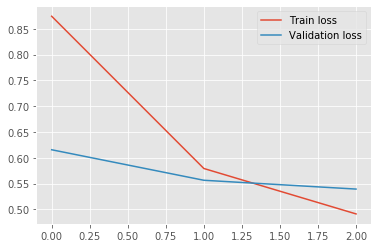

In [123]:
# когда начали переобучаться
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

### 5. Финальная обработка данных и выдача результата

In [244]:
inv_cat_encoder = {v: k for k, v in cat_encoder.items()}

def output_top3_categories(prob):
    results = tf.argsort(prob, axis=1)
    top_cats_pred = np.array([result[-3:] for result in results])
    result_df = pd.DataFrame({'Реальная категория':y_test, 
                          'Лучшая категория (прогноз)':top_cats_pred[:, -1],
                          '2-я категория (прогноз)':top_cats_pred[:, -2],
                          '3-я категория (прогноз)':top_cats_pred[:, -3],
                         })
    result_df['Реальная категория'] = result_df['Реальная категория'].map(inv_cat_encoder)
    result_df['Лучшая категория (прогноз)'] = result_df['Лучшая категория (прогноз)'].map(inv_cat_encoder)
    result_df['2-я категория (прогноз)'] = result_df['2-я категория (прогноз)'].map(inv_cat_encoder)
    result_df['3-я категория (прогноз)'] = result_df['3-я категория (прогноз)'].map(inv_cat_encoder)
    
    return result_df

In [245]:
result_df = output_top3_categories(prob)
result_df_with_news = result_df.merge(df.text, left_index=True, right_index=True)
print("Предсказание 3-х самых вероятных категорий для новостей.")
result_df_with_news.head(10)

Предсказание 3-х самых вероятных категорий для новостей.


,Реальная категория,Лучшая категория (прогноз),2-я категория (прогноз),3-я категория (прогноз),text
11200,В мире,В мире,Политика,Общество,"МОСКВА, 7 дек - РИА Новости. Заявление США о ..."
88517,Культура,Культура,Общество,Недвижимость,"МОСКВА, 14 июл — РИА Новости. Кинокритики амер..."
134796,Общество,Общество,Культура,Наука,"\nМОСКВА, 19 апр — РИА Новости. Российский евр..."
120926,В мире,В мире,Политика,Экономика,"\nВАШИНГТОН, 15 мая — РИА Новости. США винят Х..."
119441,Недвижимость,Недвижимость,Общество,Происшествия,"МОСКВА, 18 мая — РИА Недвижимость. Сцену кинок..."
74790,В мире,В мире,Происшествия,Общество,"\nМОСКВА, 9 авг — РИА Новости. Десятки рейсов ..."
100000,Экономика,Политика,Общество,Экономика,"\nМОСКВА, 22 июн — РИА Новости. Совет директор..."
142502,Экономика,Экономика,В мире,Политика,"\nМОСКВА, 5 апр — РИА Новости. Белорусским про..."
5372,Экономика,Экономика,В мире,Политика,"МОСКВА, 19 дек — РИА Новости. Стоимость нефти ..."
13087,В мире,В мире,Политика,Общество,"БРЮССЕЛЬ, 4 дек — РИА Новости. Генсек НАТО Йе..."
